In [ ]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

In [ ]:
def psi(g,e):
    return np.array([g, e])

#def pulse(t, Omega0, delPrime):
#    Omega = np.sqrt(Omega0**2 + delPrime**2)
#    
#    return np.array([[np.cos(Omega*t/2.0) -(1.0j*delPrime/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
#             [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delPrime/Omega)*np.sin(Omega*t/2.0)]])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

def ramsey(psi0, t, delta, delPrime, Omega0):
    #psi0 = initial state vector
    #t = dark time
    #delta = dark time detuning
    #delprime = pulse detuning
    #Omega0 = rabi freq.
    pi2Pulse = pulse(np.pi/(2.0*Omega0), Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(t, 0.0, delta, 0.0, 0.0)
    
    return pi2Pulse@freeEvo@pi2Pulse@psi0

def ramseyInjP(psi0, t, delta, delPrime, Omega0):
    pi2Pulse = pulse(np.pi/(2.0*Omega0), Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(t, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0) 
    
    return pi2Pulse@pi2PhaseInj@freeEvo@pi2Pulse@psi0

def ramseyInjM(psi0, t, delta, delPrime, Omega0):
    pi2Pulse = pulse(np.pi/(2.0*Omega0), Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(t, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0) 
    
    return pi2Pulse@pi2PhaseInj@freeEvo@pi2Pulse@psi0

def errSig(psi0, t, delta, delPrime, Omega0):
    RhoeeP = rhoee(ramseyInjP(psi0,t,delta,delPrime,Omega0))
    RhoeeM = rhoee(ramseyInjM(psi0,t,delta,delPrime,Omega0))
    return RhoeeP - RhoeeM

def errSig1(psi0, t, delta, delPrime, Omega0):
    RhoeeP = rhoee(ramseyInjP(psi0,t,delta,delta+delPrime,Omega0))
    RhoeeM = rhoee(ramseyInjM(psi0,t,delta,delta+delPrime,Omega0))
    return RhoeeP - RhoeeM

As in the notes from Friday 10/28, I'll call the detuning during the pulse $\delta'$ (delp), the detuning during the dark time $\delta_d$ (deld), and the difference between them $\Delta = \delta_d - \delta'$ (Delta) as in the HRS paper.

For a given $\Delta$, I'll scan $\delta'$ and $\delta_d$ common mode such that $\delta'(t) = \delta_d(t) - \Delta$ and plot the error signal against $\delta_d$ for a given $\Omega_0$ and $T$ to find the zero.

In [86]:
def validate_interval(psi0, t, Delta, Omega0, x0, x1):
    return errSig(psi0, t, x0, x0+Delta, Omega0) * errSig(psi0, t, x1, x1+Delta, Omega0) < 0

def error_bound(a, b, err):
    n = np.log((b - a) / err) / np.log(2)
    return int(np.ceil(n))

def findRoot(psi0, t, Delta, Omega0, tol):
    #find initial interval (will only work for small Delta):
    
    #pts = 100
    #delds = np.linspace(-5.0, 5.0, pts)
    #errSigPts = [0.0]*pts
    #for ii in range(pts):
    #    errSigPts[ii] = errSig(psi0, t, delds[ii], Delta+delds[ii], Omega0)
    #x0 = delds[np.argmax(errSigPts)]
    #x1= delds[np.argmin(errSigPts)]

    #I could test if the above printed x0 and x1 satisfy x0 < x1 and if they don,t move one of them over to the next 
    #local extremum. A guess of what the clock shift should be will tell you which x to move and which direction.

    #x0 = -t*Omega0*Delta/2.0 - 0.5*np.abs(t*Omega0*Delta/2.0) - 0.01
    #x1 = -t*Omega0*Delta/2.0 + 0.5*np.abs(t*Omega0*Delta/2.0) + 0.01
    
    x0 = -2.0*Delta/(Omega0*t) - 0.5*np.abs(2.0*Delta/(Omega0*t)) - 0.01
    x1 = -2.0*Delta/(Omega0*t) + 0.5*np.abs(2.0*Delta/(Omega0*t)) + 0.01
    
    #x0 = -Delta/(Omega0*t) - 0.5*np.abs(Delta/(Omega0*t)) - 0.01
    #x1 = -Delta/(Omega0*t) + 0.5*np.abs(Delta/(Omega0*t)) + 0.01
    #print(x0,x1)
    
    if not validate_interval(psi0, t, Delta, Omega0, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = errSig(psi0, t, root_approx, root_approx+Delta, Omega0)
        if -tol < y < tol:
            return root_approx
        if validate_interval(psi0, t, Delta, Omega0, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1

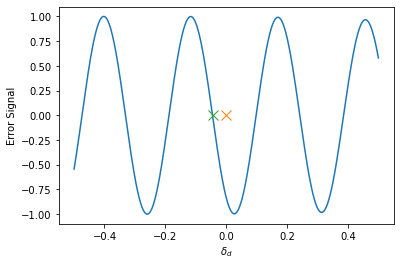

In [88]:
psi0 = psi(0.0, 1.0)
Delta = 0.5
Omega0 = 1.0
t = 20.0
tol = 1.0e-10

pts = 1000
delds = np.linspace(-0.5, 0.5, pts)
errSigPts = [0.0]*pts

for ii in range(pts):
    #def errSig(psi0, t, dark detuning, pulse detuning, Omega0):
    errSigPts[ii] = errSig(psi0, t, delds[ii], Delta+delds[ii], Omega0)
    
plt.plot(delds, errSigPts)
plt.xlabel('$\delta_d$')
plt.ylabel('Error Signal')
plt.plot([0.0], [0.0], marker="x", markersize=10)
plt.plot([findRoot(psi0, t, Delta, Omega0, tol)], [0.0], marker="x", markersize=10)
plt.show()

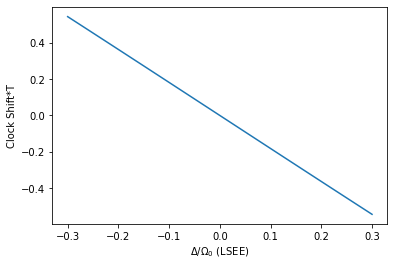

In [90]:
psi0 = psi(0.0, 1.0)
t = 20.0
Omega0 = 1.0
tol = 1.0e-7

pts = 101
Deltas = np.linspace(-0.3, 0.3, pts)
clockShifts = [0.0]*pts

for ii in range(pts):
    clockShifts[ii] = t*findRoot(psi0, t, Deltas[ii], Omega0, tol)
    
plt.plot(Deltas, clockShifts)
plt.xlabel("$\Delta / \Omega_0$ (LSEE)")
plt.ylabel('Clock Shift*T')
plt.show()